In [1]:
#------------------------------------------------------------------------------
# Project 2
# Written by: Harsh Deep Kour(40082906) and Iknoor Singh Arora(40082312)
# For COMP 6721 Section: FK (1779) - Fall 2019
#------------------------------------------------------------------------------

import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import numpy as np
import math 
import matplotlib.pyplot as plt
#nltk.download()

In [2]:
#data = pd.read_csv(r'/Users/harshkour/Desktop/AI-P2/hn2018_2019-2.csv')
data = pd.read_csv(r'hn2018_2019.csv')

In [3]:
traindata=data[(data['Created At'] > '2018-01-01') & (data['Created At'] < '2019-01-01')]
traindatalen=len(traindata)
print("No. of records in Training are: " + str(traindatalen))

No. of records in Training are: 90


In [4]:
testdata=data[(data['Created At'] >= '2019-01-01')]
print("No. of records in Testing are: " + str(len(testdata)))


No. of records in Testing are: 10


In [5]:
Post_Type_required = ['story','ask_hn','show_hn','poll']

In [6]:
#function for Pos tag mapping 
def pos_mapping(word_tag):
        
    if word_tag.startswith('J'):
        return wordnet.ADJ
    elif word_tag.startswith('V'):
        return wordnet.VERB
    elif word_tag.startswith('N'):
        return wordnet.NOUN
    elif word_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.ADV


In [7]:
#Creating vocabulary for training data
lemmat = WordNetLemmatizer()

vocablist=[]
bigramslist = []
unique_bigrams =[]
nonvocablist = []
nonvocab_unique = []
#english_vocab = nltk.corpus.words.words()


for i, row in traindata.iterrows():
    final=' '
    bigrams_final = []
    unigram = []
    nonunigram = []
    vocab = []
    pattern = '[\w]+'
    tokenizer = RegexpTokenizer(pattern)
    title = row.Title
    title = title.replace("'","")
    list_wordtokenized=tokenizer.tokenize(title)# tokenization using regextokenizer
    posttag_list = pos_tag(list_wordtokenized)#finding pos tags
    bigrams = list(nltk.bigrams(posttag_list))#libray for bigram creation
    
    #creating bygrams for pos_tags starting with N
    for (w1,w2) in bigrams :
        
        flagw1 = False
        flagw2 = False
        flag_w1 = False
        flag_w2 = False
        posw1 = pos_mapping(w1[1])
        posw2 = pos_mapping(w2[1])
        lemword1=(lemmat.lemmatize(w1[0],posw1)).lower()
        lemword2=(lemmat.lemmatize(w2[0],posw2)).lower()
        
        
        if('_' in lemword1):
            word1 = lemword1.replace("_","")
            if word1.isalpha():
                flag_w1 = True 
        if('_' in lemword2):
            word2 = lemword2.replace("_","")
            if word2.isalpha():
                flag_w2 = True 
        #if (lemword1.isalpha() and len(lemword1)!=1) or flag_w1 or (len(lemword1)==1 and (lemword1 == 'a' or lemword1 == 'i')):
        if (lemword1.isalpha()) or flag_w1:
            flagw1 = True
        else:
            nonvocablist.append(lemword1) 
        #if (lemword2.isalpha() and len(lemword2)!=1) or flag_w2 or (len(lemword2)==1 and (lemword2 == 'a' or lemword2 == 'i')):
        if (lemword2.isalpha()) or flag_w2:    
            flagw2 = True
        else:
            nonvocablist.append(lemword2)
            
        if posw1 == 'n' and posw2 == 'n' and flagw1 and flagw2:
            x = "%s %s" % (lemword1.strip(),lemword2.strip())
            bigrams_final.append(x)
            nonunigram.append(lemword1)
            nonunigram.append(lemword2)
        else:
            if flagw1:
                unigram.append(lemword1)
            if flagw2:
                unigram.append(lemword2)
                
    unigram_final = list(set(unigram) - set(nonunigram))
    vocab.extend(unigram_final)
    vocab.extend(bigrams_final)
    vocablist.extend(vocab)
    bigramslist.extend(bigrams_final)
    
    traindata.at[i, 'Title']= vocab

unique_bigrams = np.unique(bigramslist)
vocab_unique=np.unique(vocablist)
vocab_unique=list(vocab_unique)
vocab_unique.sort()
nonvocab_unique=np.unique(nonvocablist)
nonvocab_unique=list(nonvocab_unique)
nonvocab_unique.sort()
print("Length of Training Vocabulary is :" + str(len(vocab_unique)))
print("Number of Bigrams in Vocabulary are: " + str(len(unique_bigrams)))
print("No. of words removed are :" + str(len(nonvocab_unique)))

Length of Training Vocabulary is :475
Number of Bigrams in Vocabulary are: 185
No. of words removed are :10


In [8]:
#Creating a vocabulary file
vocabfile = open('vocabulary.txt', "w",encoding="utf-8")
vocabfile.write("\n".join(str(item) for item in vocab_unique))
vocabfile.close()

In [9]:
#Creating a remove words file 
nonvocabfile = open('remove_word.txt', "w",encoding="utf-8")
nonvocabfile.write("\n".join(str(item) for item in nonvocab_unique))
nonvocabfile.close()

In [10]:
type_dict = {} # 2d dictionary for each word's frequency corresponding to class

new_list = Post_Type_required
prob_type_dict={} # dictionary for class score

for type_value in new_list:
    all_rows = traindata.loc[traindata['Post Type'] == type_value]
    print(type_value)
    print(len(all_rows))
    prob_type_dict[type_value]=len(all_rows)/traindatalen
    type_dict[type_value]=pd.Series(np.concatenate([x for x in all_rows['Title']])).value_counts()

story
30
ask_hn
20
show_hn
30
poll
10


In [11]:
#function for creating the model and adding probability values for each class for words in model text file.
#It returns main dictionary and test dictionary which has prob and freq corresponding to each word.

def model_building(file_name_writeread,file_name_write,smooth_factor):
    file_text = open(file_name_writeread, "w", encoding="utf-8")
    main_dict = {} # 2d dictionary type - word - freq/classtype +probability/classtype
    for post_type,val in type_dict.items():
        sumval= sum(type_dict[post_type])
        main_dict[post_type] = {}
        word_dict = {}
        for word in vocab_unique:
            word_freq=0
            if(word in type_dict[post_type]):     
                word_freq=type_dict[post_type][word]

            probab=(word_freq+smooth_factor)/(sumval+len(vocab_unique))
            word_dict[word] = str(word_freq) + "  " + str(probab)
            
        main_dict[post_type] = word_dict

 
    post_type_list = []
    counter = 0
    test_dict = {}
    for word in vocab_unique:
        prob_word = []
        counter = counter + 1
        freprobstr = ""
        for keys in main_dict.keys():
            #print("key is " + str(keys))
            w_dict = main_dict[keys]
            freqprob = w_dict[word].split("  ")

            prob_word.append(float(freqprob[1]))
            if freprobstr == "":
                freprobstr =  w_dict[word]
            else:
                freprobstr = "  " + freprobstr + "  " + w_dict[word]
        test_dict[word] = prob_word
        word = str(word).strip()   
        file_text.write(str(counter) + "  " + word + "  " + freprobstr.strip() + "\r\n")  

    #print(main_dict)
    file_text.close()
    return main_dict,test_dict              

In [12]:
#function for calculating total probability of the words in the title for each class
def calcvocabscore(main_dict,test_dict):
    Score_dict = {}   
    for word in test_dict:
        final_classscores_list = []       
        probclasslist =  test_dict[word]
        word_log0= math.log(probclasslist[0],10)
        word_log1= math.log(probclasslist[1],10)
        word_log2= math.log(probclasslist[2],10)
        word_log3= math.log(probclasslist[3],10)
        
        final_classscores_list.append(word_log0)
        final_classscores_list.append(word_log1)
        final_classscores_list.append(word_log2)
        final_classscores_list.append(word_log3)
        
        Score_dict[word] = final_classscores_list
    return Score_dict

In [13]:
#Naive Bayes Implementation and test file generation

def naive_bayes(file_name_writeread,file_name_write,main_dict,test_dict,Score_dict):
    file_result = open(file_name_write, "w",encoding="utf-8")
    line_counter=0
    predicted_class=[]
    actual_class=[]
    classes_list=[]   
    classscores = []
    class_prob_testlist=[]
    for class_type in main_dict.keys():
        class_prob_testlist.append(class_type)
        class_score = prob_type_dict[class_type] # class score
        word_log = math.log(class_score,10)
        classscores.append(word_log)

    for i, row in testdata.iterrows():
        final_classscores_str=""
        final_classscores_list=[]
        
        line_counter=line_counter+1
        result_string=""
        label_correct=testdata.at[i,'Post Type']
        
        word_log0 = classscores[0]
        word_log1 = classscores[1]
        word_log2 = classscores[2]
        word_log3 = classscores[3]
                
        title_put=' '
        unigram = []
        nonunigram = []
        vocab = []
        pattern = '[\w]+'
        tokenizer = RegexpTokenizer(pattern)
        title_put = row.Title
        title = title_put.replace("'","")
        list_wordtokenized=tokenizer.tokenize(title)
        posttag_list = pos_tag(list_wordtokenized)
        bigrams = list(nltk.bigrams(posttag_list))
        for (w1,w2) in bigrams :       
            flagw1 = False
            flagw2 = False
            flag_w1 = False
            flag_w2 = False
            posw1 = pos_mapping(w1[1])
            posw2 = pos_mapping(w2[1])
            lemword1=(lemmat.lemmatize(w1[0],posw1)).lower()
            lemword2=(lemmat.lemmatize(w2[0],posw2)).lower()
            
            if('_' in lemword1):
                word1 = lemword1.replace("_","")
                if word1.isalpha():
                    flag_w1 = True 
            if('_' in lemword2):
                word2 = lemword2.replace("_","")
                if word2.isalpha():
                    flag_w2 = True 
            if (lemword1.isalpha()) or flag_w1:
                flagw1 = True
            else:
                nonvocablist.append(lemword1) 
            if (lemword2.isalpha()) or flag_w2:    
                flagw2 = True
            else:
                nonvocablist.append(lemword2)  
            if posw1 == 'n' and posw2 == 'n' and flagw1 and flagw2:
                x = "%s %s" % (lemword1.strip(),lemword2.strip())
                unigram.append(x)
                nonunigram.append(lemword1)
                nonunigram.append(lemword2)      
                if x in test_dict:
                    val = Score_dict[x]
                    word_log0=word_log0+val[0]
                    word_log1=word_log1+val[1]
                    word_log2=word_log2+val[2]
                    word_log3=word_log3+val[3]
                if lemword1 in unigram:
                    unigram.remove(lemword1)
                    if (lemword1 in test_dict):
                        val = Score_dict[lemword1]
                        word_log0=word_log0-(val[0])
                        word_log1=word_log1-(val[1])
                        word_log2=word_log2-(val[2])
                        word_log3=word_log3-(val[3])
                if lemword2 in unigram:
                    unigram.remove(lemword2)
                    if (lemword2 in test_dict):
                        val = Score_dict[lemword2]
                        word_log0=word_log0-(val[0])
                        word_log1=word_log1-(val[1])
                        word_log2=word_log2-(val[2])
                        word_log3=word_log3-(val[3])
            else:
                if flagw1 and (lemword1 not in unigram) and (lemword1 not in nonunigram):
                    unigram.append(lemword1)
                    if lemword1 in test_dict:
                        val = Score_dict[lemword1]
                        word_log0=word_log0+val[0]
                        word_log1=word_log1+val[1]
                        word_log2=word_log2+val[2]
                        word_log3=word_log3+val[3]
                if flagw2 and (lemword2 not in unigram) and (lemword2 not in nonunigram):
                    unigram.append(lemword2)
                    if lemword2 in test_dict:
                        val = Score_dict[lemword2]
                        word_log0=word_log0+val[0]
                        word_log1=word_log1+val[1]
                        word_log2=word_log2+val[2]
                        word_log3=word_log3+val[3]
                   
        

        final_classscores_list.append(word_log0)
        final_classscores_list.append(word_log1)
        final_classscores_list.append(word_log2)
        final_classscores_list.append(word_log3)
        word_log0 = ("{:12.10f}".format(word_log0))
        word_log1 = ("{:12.10f}".format(word_log1))
        word_log2 = ("{:12.10f}".format(word_log2))
        word_log3 = ("{:12.10f}".format(word_log3))
        if final_classscores_str == "":
            final_classscores_str = str(word_log0) + "  " + str(word_log1)+ "  " + str(word_log2)+ "  " + str(word_log3)

            
        max_probscore_index=final_classscores_list.index(max(final_classscores_list))
        label_classified=class_prob_testlist[max_probscore_index]
        rel=""
        if label_classified == label_correct:
            rel="right"
        else:
            rel="wrong"
        actual_class.append(label_correct)
        predicted_class.append(label_classified)
        result_string=result_string+str(line_counter)+"  "+str(title_put)+"  "+str(label_classified)+"  "+str(final_classscores_str)+"  "+str(label_correct)+"  "+rel
        file_result.write(result_string + "\r\n")
    file_result.close()
    classes_list= np.unique(actual_class)
    return (actual_class,predicted_class,classes_list)
                               

In [14]:
#results analysis

def result_analysis(actual_class,predicted_class,experiment,classes_list):
    
    
    experiment=experiment.strip()
    
    if experiment=='exp1' or experiment=='exp2' or experiment=='exp3'or experiment=='exp4' or experiment=='exp5':
        
        print("experiment:-",experiment)
        print("\n")
        print("----confusion matrix----")
        cm = pd.DataFrame(confusion_matrix(actual_class,predicted_class),columns=classes_list,index=classes_list)
        print(cm)
        print("\n")
        print("----classification report----")
        print(classification_report(actual_class,predicted_class ,target_names=classes_list))
        print("\n")
        print("----Accuracy report----")
        print(accuracy_score(actual_class, predicted_class))

    if experiment=='exp5' or experiment=='exp4' :
        
        accuracy_diffsmooth.append(accuracy_score(actual_class, predicted_class))
   
    #print("accuracy_diffsmooth",accuracy_diffsmooth)
        

Enter the experiment no.(exp1/exp2/exp3/exp4/exp5)exp5
experiment:- exp5


----confusion matrix----
         ask_hn  poll  show_hn  story
ask_hn        2     0        0      0
poll          1     1        0      1
show_hn       0     0        2      0
story         0     0        0      3


----classification report----
              precision    recall  f1-score   support

      ask_hn       0.67      1.00      0.80         2
        poll       1.00      0.33      0.50         3
     show_hn       1.00      1.00      1.00         2
       story       0.75      1.00      0.86         3

    accuracy                           0.80        10
   macro avg       0.85      0.83      0.79        10
weighted avg       0.86      0.80      0.77        10



----Accuracy report----
0.8
experiment:- exp5


----confusion matrix----
         ask_hn  poll  show_hn  story
ask_hn        2     0        0      0
poll          2     0        0      1
show_hn       0     0        2      0
story         0 

/Users/harshkour/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


experiment:- exp5


----confusion matrix----
         ask_hn  poll  show_hn  story
ask_hn        2     0        0      0
poll          2     0        0      1
show_hn       0     0        2      0
story         0     0        0      3


----classification report----
              precision    recall  f1-score   support

      ask_hn       0.50      1.00      0.67         2
        poll       0.00      0.00      0.00         3
     show_hn       1.00      1.00      1.00         2
       story       0.75      1.00      0.86         3

    accuracy                           0.70        10
   macro avg       0.56      0.75      0.63        10
weighted avg       0.53      0.70      0.59        10



----Accuracy report----
0.7
experiment:- exp5


----confusion matrix----
         ask_hn  poll  show_hn  story
ask_hn        2     0        0      0
poll          2     0        0      1
show_hn       0     0        2      0
story         0     0        0      3


----classification report----
 

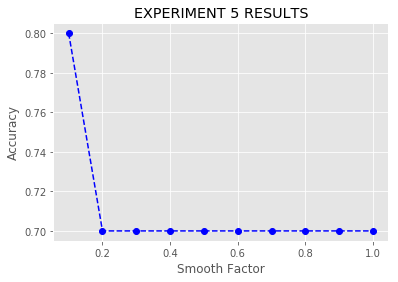

Program finished


In [15]:
#Class for performing experiments for different vocab size and smoothing factor
experiment= input("Enter the experiment no.(exp1/exp2/exp3/exp4/exp5)").strip()
smooth_factor=0.5
#baseline experiment
if experiment=='exp1':
    
    file_name_writeread="model-2018.txt"
    file_name_write="baseline-result.txt"
    
    main_dict,test_dict= model_building(file_name_writeread,file_name_write,smooth_factor)
    Score_dict = calcvocabscore(main_dict,test_dict)   
    actual_class,predicted_class,classes_list=naive_bayes(file_name_writeread,file_name_write,main_dict,test_dict,Score_dict)
    result_analysis(actual_class,predicted_class,experiment.strip(),classes_list)
    
    
    print("Program finished")
#stopword removal    
elif experiment=='exp2':
    
    stopwords_file=open(r"Stopwords.txt", "r",encoding="utf-8")
    file_cont=stopwords_file.read()
    file_cont.replace("'","")
    lines=file_cont.splitlines()
    
    for word in vocab_unique:
        if word in lines:
            vocab_unique.remove(word)
        elif ' ' in word:
            bigram = word.split(' ')
            for b in bigram:
                if (b in lines) and word in vocab_unique:
                    vocab_unique.remove(word)       
     
     
    vocab_unique.sort()
    file_name_writeread="stopword-model.txt"
    file_name_write="stopword-result.txt" 
    
    main_dict,test_dict=model_building(file_name_writeread,file_name_write,smooth_factor)
    Score_dict = calcvocabscore(main_dict,test_dict)
    actual_class,predicted_class,classes_list=naive_bayes(file_name_writeread,file_name_write,main_dict,test_dict,Score_dict)
    result_analysis(actual_class,predicted_class,experiment.strip(),classes_list)
    
    print("Program finished")
    
#word-length filtering    
elif experiment=='exp3':
    
    new_vocab=[]
    for word in vocab_unique:
        if (len(word)>=3 and len(word)<=8):
            new_vocab.append(word)
    vocab_unique=new_vocab 
    vocab_unique.sort()
    
    file_name_writeread="wordlength-model.txt"
    file_name_write="wordlength-result.txt"
    
    main_dict,test_dict=model_building(file_name_writeread,file_name_write,smooth_factor)
    Score_dict = calcvocabscore(main_dict,test_dict)
    actual_class,predicted_class,classes_list=naive_bayes(file_name_writeread,file_name_write,main_dict,test_dict,Score_dict)
    result_analysis(actual_class,predicted_class,experiment.strip(),classes_list)
    
    print("Program finished")
    
#frequency filtering   
elif experiment=='exp4':
    new_vocab_len=[]
    accuracy_diffsmooth=[]
    total_freq_dict={} 
     
    unique, counts = np.unique(vocablist, return_counts=True)
    total_freq_dict = dict(zip(unique, counts))
    
    vocabset= set(total_freq_dict.keys())
    
    sorted(total_freq_dict.items(), key=lambda x: x[1])
    
    freq_removal=['1','l5','l10','l15','l20','p5','p10','p15','p20','p25']
    less_flag=False
    percent_flag=False
    
    for freq in freq_removal:
        #print("Value is ---- "+ str(freq))
        
        remove_words=[]
        
        if len(freq)>1:
            if(freq[0]=='l'):
                less_flag=True 
            else:
                less_flag=False
                percent_flag=True
                
            freq=int(freq[1:])
        
        if(percent_flag is True):
            dict_len=len(total_freq_dict.items())
            num_words=int((freq/100)*dict_len)
            #print(num_words)
            num_wordst = num_words
            list2 = list(total_freq_dict.values())
            valuelist, counts = np.unique(list2, return_counts=True)
            valuedict = dict(zip(valuelist, counts))
            valuetoberemoved = []
            lastvalueremoved = 0
            #print(list2)
            while(num_words>0):
                maxval = max(list2)
                #print("maximum value is " + str(maxval))
                count = valuedict[maxval]
                list2 = list(filter(lambda a: a != maxval, list2))
                #print("count is " + str(count))
                num_words = num_words - count
                #print("numwords is " + str(num_words))
                if num_words >= 0:
                    valuetoberemoved.append(maxval)
                else:
                    lastvalueremoved = maxval
                    #print("last value to be removed " + str(lastvalueremoved))
                #print(valuetoberemoved) 
                
                
            counting=0
            
            for word in total_freq_dict:
                word_freq = total_freq_dict[word]
                if(word_freq in valuetoberemoved) and (word in total_freq_dict) and counting<num_wordst:
                    vocabset.discard(word)
                    remove_words.append(word)
                    counting=counting+1
                if counting>=num_wordst:
                    break
            
            #print(remove_words)
            
            if lastvalueremoved != 0:
                for word in total_freq_dict:
                    word_freq = total_freq_dict[word]
                    if word_freq == lastvalueremoved:
                        vocabset.discard(word)
                        remove_words.append(word)
                        counting=counting+1
                        if counting>=num_wordst:
                            break
                      
        else:   
            if (less_flag is False) :
                for word in total_freq_dict: 
                    word_freq = total_freq_dict[word]
                    if(word_freq == int(freq)):
                        if(word in total_freq_dict):
                            vocabset.discard(word)
                            remove_words.append(word)
                      

            elif (less_flag is True):
                for word in total_freq_dict: 
                    word_freq = total_freq_dict[word]
                    if(word_freq<=freq):
                        if(word in total_freq_dict):
                            vocabset.discard(word) 
                            remove_words.append(word) 
        
        vocab_unique = list(vocabset - set(remove_words))
        for wor in remove_words:
            if wor in total_freq_dict:
                del total_freq_dict[wor]
        
        #print(total_freq_dict)
        vocab_unique.sort()
        
        new_vocab_len.append(len(vocab_unique))

        file_name_writeread="model-2018.txt"
        file_name_write="baseline-result.txt"

        #print("modelling started")
        main_dict,test_dict=model_building(file_name_writeread,file_name_write,smooth_factor)
        #print("modelling done")
        Score_dict = calcvocabscore(main_dict,test_dict)
        #print("calc score done")
        actual_class,predicted_class,classes_list=naive_bayes(file_name_writeread,file_name_write,main_dict,test_dict,Score_dict)
        #print("naivebyes done")
        result_analysis(actual_class,predicted_class,experiment.strip(),classes_list)
        #print("result analysis done")
    
    print("Remaining words in Vocab: \n",new_vocab_len)
    print("Accuracy: \n",accuracy_diffsmooth)
    plt.style.use('ggplot')
    plt.plot(new_vocab_len, accuracy_diffsmooth,linestyle='--', marker='o', color='b') 
    plt.xlabel('Number of words remaining in vocab')
    plt.ylabel('Accuracy')
    plt.title("EXPERIMENT 4 RESULTS")
    plt.show()
    
    print("Program finished")
    
#changing smoothing factor    
elif experiment=='exp5':
    
    accuracy_diffsmooth=[]
    list_val=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    
    file_name_writeread="model-2018.txt"
    file_name_write="baseline-result.txt"
    
    for i in list_val:
        
        smooth_factor=i
    
        main_dict,test_dict=model_building(file_name_writeread,file_name_write,smooth_factor)
        Score_dict = calcvocabscore(main_dict,test_dict)
        actual_class,predicted_class,classes_list=naive_bayes(file_name_writeread,file_name_write,main_dict,test_dict,Score_dict)
        result_analysis(actual_class,predicted_class,experiment.strip(),classes_list)
    
    print("Smooth Factor: \n",list_val)
    print("Accuracy: \n",accuracy_diffsmooth)
    plt.style.use('ggplot')
    plt.plot(list_val, accuracy_diffsmooth,linestyle='--', marker='o', color='b') 
    plt.xlabel('Smooth Factor')
    plt.ylabel('Accuracy')
    plt.title("EXPERIMENT 5 RESULTS")
    plt.show()
    
    print("Program finished")
else:
    print("Incorrect experiment no. has beeen entered")
    print("Program finished")